DeepRitz ML model for solving the monodomain problem 
Using the IMEX time dependend formula 

In [19]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F


In [20]:
# n_x, n_y grid size for x and y
# sigma_h, sigma_d conductivity of healthy and diseased regions
# dr, lists of the diseased regions points (x_center, y_center, radius) to fit the (x−0.3)^2 +(y−0.7)^2 <0.1^2 formulas
# returns a 2D array of all the points in the grid with the healthy and diseased regions marked
def cond_map(n_x, n_y, sigma_h, sigma_d, dr):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    sigma = np.full((n_x, n_y), sigma_h)

    for (xc, yc, r) in dr:
        mask = (X - xc)**2 + (Y - yc)**2 < r**2
        sigma[mask] = sigma_d

    return sigma


Initial condition function

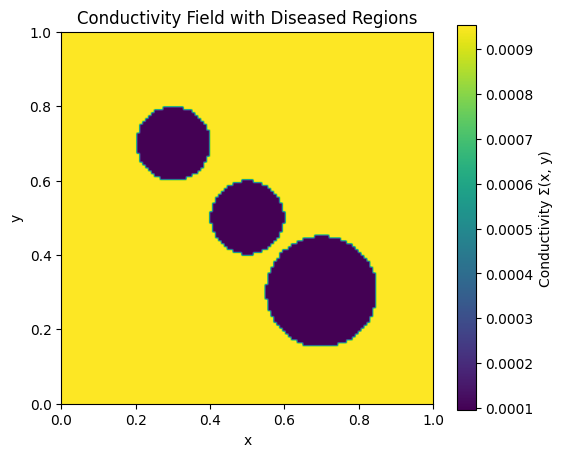

In [22]:
# params
n_x, n_y = 128, 128
dr = [(0.3, 0.7, 0.1), (0.7, 0.3, 0.15), (0.5, 0.5, 0.1)]
sigma_h = 9.5298e-4
# sigma_d = 10 * sigma_h
# sigma_d = sigma_h
sigma_d = 0.1 * sigma_h
a = 18.515
ft = 0.2383
fr = 0
fd = 1
T = 35
sigma = cond_map(n_x, n_y, sigma_h, sigma_d, dr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sigma_t = torch.tensor(sigma.flatten(), dtype=torch.float32).to(device)


# heart map values
plt.figure(figsize=(6, 5))
plt.imshow(sigma.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
plt.colorbar(label='Conductivity Σ(x, y)')
plt.title('Conductivity Field with Diseased Regions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()



In [23]:
# u0(x, y) = 1 if x ≥ 0.9 and y ≥ 0.9, else 0.
# returns u0 as a 2D array
def ic(n_x, n_y):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')

    u0 = np.zeros((n_x, n_y))
    u0[(X >= 0.9) & (Y >= 0.9)] = 1.0
    return u0

Reaction term

In [24]:
# reaction term 
def R(u, a, fr, ft, fd):
    return a * (u - fr) * (u - ft) * (u - fd)

RHS of the IMEX eq

In [25]:
# RHS = (1/dt) * u^n - f(u^n)
# u_n, solution at time step n
# dt : time step size
# returns a 2D array pf the rhs
def rhs(u_n, a, fr, ft, fd, dt):
    f_un = R(u_n, a, fr, ft, fd)
    return (1.0 / dt) * u_n - f_un

Model 

In [72]:
class DeepRitz(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, w=64, d=4):
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(w if i>0 else input_dim, w) for i in range(d)])
        self.linearOut = nn.Linear(w, output_dim)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)   # can be a different normalization function
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.softplus(self.linear[0](x))  
        for layer in self.linear[1:]:
            x_temp = F.softplus(layer(x))
            x = x + x_temp
        return self.linearOut(x)


Sample points

In [59]:
def sample_cps(N, domain=(0, 1)):
    x = np.random.uniform(domain[0], domain[1], size=(N,))
    y = np.random.uniform(domain[0], domain[1], size=(N,))
    return torch.tensor(np.stack([x, y], axis=-1), dtype=torch.float32)

Energy function

In [83]:
# interpolation functions to allow samplinh at the collocation points
def rhs_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return rhs_t[idx_x * n_y + idx_y].unsqueeze(1)

def sigma_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return sigma_t[idx_x * n_y + idx_y].unsqueeze(1)

def energy_f(model, points, sigma_norm, rhs_norm, dt, x):
    x.requires_grad_(True)
    u = model(x).squeeze()
    grad_u = autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0] # ∇u^{n+1}
    sigma_vals = sigma_norm(points).squeeze()        # sigma(x, y)
    rhs_vals = rhs_norm(points).squeeze()            # (1/dt) u^n - f(u^n)

    grad_norm_sq = (grad_u**2).sum(dim=1)            # ||grad(u)||²

    # M u^(n+1) + dt K u^{n+1} = M u^n - dt f(u^n)
    # where K = 1/2 *sigma * grad^2
    energy = 0.5 * sigma_vals * grad_norm_sq + (0.5 / dt) * u**2 - rhs_vals * u
    return energy.mean() 

Training 

In [66]:
# training func
def train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device):
    model.train()
    points = points.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(steps):
        optimizer.zero_grad()
        loss = energy_f(model, points, sigma_norm, rhs_norm, dt, points)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % (steps // 10 if steps >= 10 else 1) == 0:
            print(f"    Epoch [{epoch+1}/{steps}], Loss: {loss.item():.8f}")
    
    return model, losses

In [73]:
# //// param def ////////////////////
dt = 0.5
N = int(T/dt)
steps = 1000
colloc_p = 1024
w = 64 
d = 4
lr = 1e-4  # could get smaller 

model = DeepRitz(input_dim=2, output_dim=1, w=w, d=d).to(device)

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')
xy_coords = np.stack([X.flatten(), Y.flatten()], axis=-1)
xy_t = torch.tensor(xy_coords, dtype=torch.float32).to(device)

u_n = ic(n_x, n_y)
u_n = torch.tensor(u_n.flatten(), dtype=torch.float32)
u_np = u_n.detach().numpy().reshape(n_x, n_y)

rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)


Using device: cpu


In [74]:
tot_losses = [] 

for n in range(int(N)):
    print(f"iter: {n} ###############################")

    points = sample_cps(colloc_p)
    model, losses = train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device)
    tot_losses.extend(losses)

    with torch.no_grad():
        u_pred = model(xy_t).squeeze().cpu()
    u_n = u_pred.clone()
    u_np = u_n.numpy().reshape(n_x, n_y)
    rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
    rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)

iter: 0 ###############################
    Epoch [100/1000], Loss: -0.00041681
    Epoch [200/1000], Loss: -0.00069789
    Epoch [300/1000], Loss: -0.00070808
    Epoch [400/1000], Loss: -0.00071817
    Epoch [500/1000], Loss: -0.00018281
    Epoch [600/1000], Loss: -0.00073450
    Epoch [700/1000], Loss: -0.00074421
    Epoch [800/1000], Loss: -0.00075270
    Epoch [900/1000], Loss: -0.00076197
    Epoch [1000/1000], Loss: -0.00077204
iter: 1 ###############################
    Epoch [100/1000], Loss: -0.00056272
    Epoch [200/1000], Loss: -0.00062588
    Epoch [300/1000], Loss: -0.00024095
    Epoch [400/1000], Loss: -0.00062765
    Epoch [500/1000], Loss: -0.00062863
    Epoch [600/1000], Loss: -0.00062957
    Epoch [700/1000], Loss: -0.00061622
    Epoch [800/1000], Loss: -0.00063173
    Epoch [900/1000], Loss: -0.00061951
    Epoch [1000/1000], Loss: -0.00059878
iter: 2 ###############################
    Epoch [100/1000], Loss: -0.00131293
    Epoch [200/1000], Loss: -0.0014983

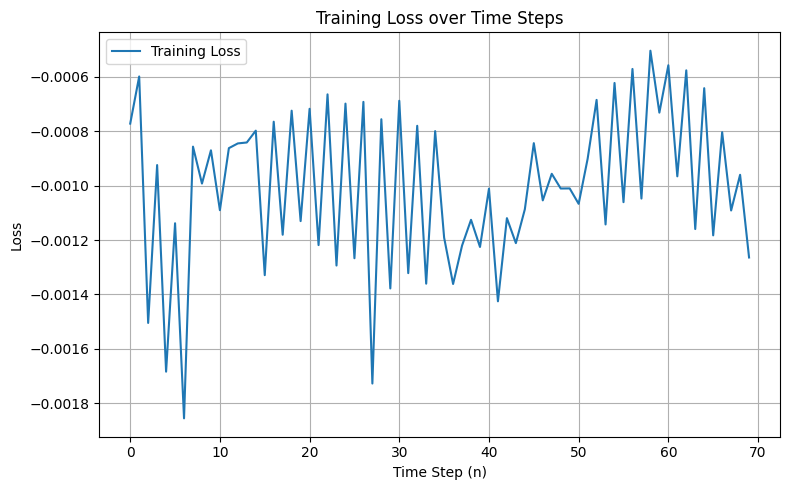

In [76]:
steps = 1000  
N = len(tot_losses) // steps 

losses_per_n = [tot_losses[i * steps + (steps - 1)] for i in range(N)]
plt.figure(figsize=(8, 5))
plt.plot(losses_per_n, label='Training Loss')
plt.xlabel("Time Step (n)")
plt.ylabel("Loss")
plt.title("Training Loss over Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

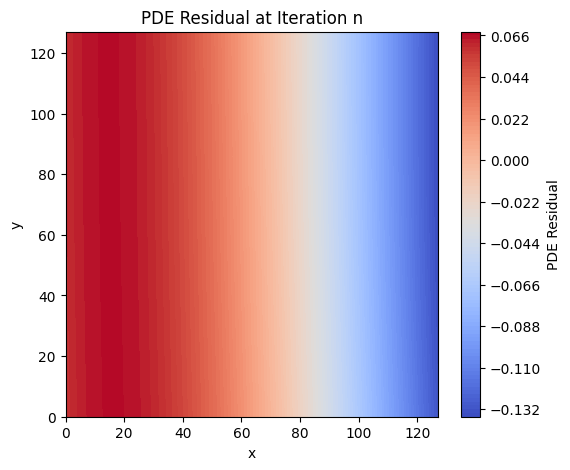

In [82]:
def pde_residual(model, u_n, sigma_norm, rhs, dt, n_x, n_y, device):
    x = torch.linspace(0, 1, n_x)
    y = torch.linspace(0, 1, n_y)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    xy.requires_grad_(True)
    u_pred = model(xy).squeeze()
    grad_u = torch.autograd.grad(u_pred, xy, grad_outputs=torch.ones_like(u_pred),
                                 create_graph=True, retain_graph=True)[0]

    sigma_vals = sigma_norm(xy).squeeze()
    flux = sigma_vals.unsqueeze(-1) * grad_u

    div_flux = torch.autograd.grad(flux, xy, grad_outputs=torch.ones_like(flux),
                                    create_graph=True, retain_graph=True)[0]
    div_flux_sum = div_flux.sum(dim=1)
    u_n_interp = u_n.detach().to(device)
    rhs_grid = rhs(u_n_interp.cpu().numpy().reshape(n_x, n_y), a, fr, ft, fd, dt)
    rhs_tensor = torch.tensor(rhs_grid.flatten(), dtype=torch.float32).to(device)
    residual = -div_flux_sum - rhs_tensor
    return residual.detach().cpu().numpy().reshape(n_x, n_y)

residual = pde_residual(model, u_n, sigma_norm, rhs, dt, n_x, n_y, device)

plt.figure(figsize=(6, 5))
plt.contourf(residual, levels=100, cmap='coolwarm')
plt.colorbar(label='PDE Residual')
plt.title("PDE Residual at Iteration n")
plt.xlabel("x")
plt.ylabel("y")
plt.show()